In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
catdata = pd.read_csv(r"D:\python\hierarchical_clustering_cats\publisheddata-scientificreports.csv")
catdata

,ID_number,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,...,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem,Aggression_component,Shyness_component,Extraversion_component
0,1,4.0274,2,1,BEN,8,0,1,4,5,...,1,1,2,1,1.0,0.0,1.0,-0.392731,-0.364198,0.666318
1,2,2.1096,2,1,BEN,8,0,1,5,4,...,1,1,3,3,1.0,0.0,1.0,-0.633626,1.419777,0.994083
2,3,7.6822,1,1,BUR,4,0,1,4,5,...,1,1,2,1,4.0,3.0,2.0,-0.392731,-0.364198,0.666318
3,4,5.0027,1,1,BUR,4,4,0,5,5,...,1,2,1,1,1.0,0.0,1.0,0.090309,-0.780989,1.330449
4,5,5.0137,1,1,EUR,4,5,1,4,5,...,1,1,2,1,1.0,0.0,1.0,-0.392731,-0.364198,0.666318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,5722,11.1151,1,1,NFO,4,3,1,3,5,...,1,1,1,1,1.0,4.0,2.0,-0.310983,-1.112740,-0.172159
5722,5723,6.3644,1,0,NFO,4,5,1,4,3,...,1,1,2,2,1.0,0.0,1.0,-0.513650,0.159206,-0.516500
5723,5724,3.1205,1,1,NFO,4,4,1,4,5,...,1,1,2,1,3.0,0.0,1.0,-0.392731,-0.364198,0.666318
5724,5725,3.6274,1,1,NFO,5,1,1,5,3,...,1,1,4,3,2.0,4.0,1.0,-0.733206,1.983008,0.479449


In [3]:
# Group by 'Breed_group'
final_result_filtered = (
    catdata.groupby('Breed_group')
    .mean(numeric_only=True)
    .iloc[:, [17, 18, 19]]
)
final_result_filtered

final_result_filtered = final_result_filtered[final_result_filtered.index !="other"]
final_result_filtered = final_result_filtered[final_result_filtered.index != "HCS"]


In [4]:
scaler = StandardScaler()
finaldf_scaled = scaler.fit_transform(final_result_filtered)


In [5]:
# Perform hierarchical clustering using the linkage method (directly on the scaled data)
Z = linkage(finaldf_scaled, method='ward')


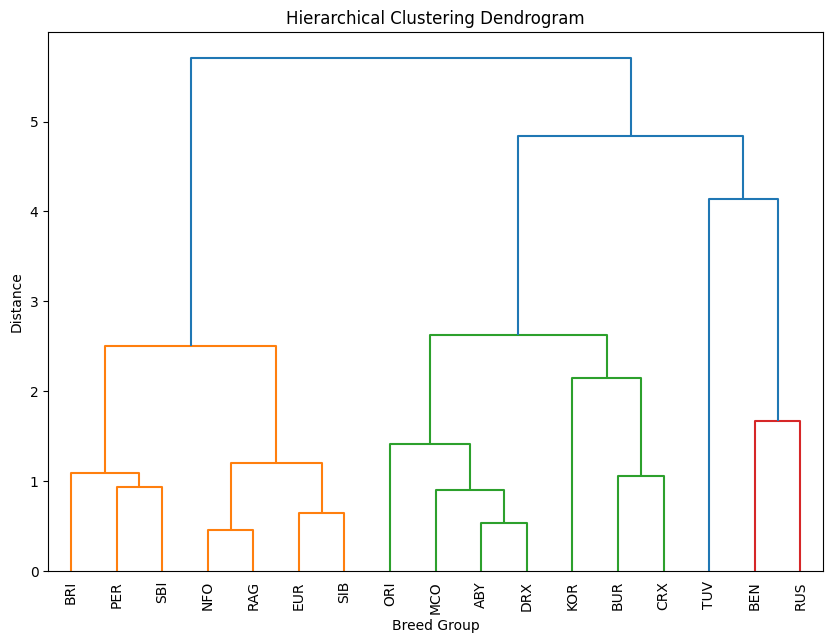

In [6]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=final_result_filtered.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Breed Group')
plt.ylabel('Distance')
plt.show()

In [31]:
from scipy.spatial.distance import pdist, squareform
def ward_d2_update(d_ik, d_jk, d_ij, memb_i, memb_j, memb_k):
    """
    Lance-Williams formula for Ward.D2 method (squared dissimilarities).
    """
    temp = (memb_i + memb_k) * d_ik + (memb_j + memb_k) * d_jk - memb_k * d_ij
    return temp / (memb_i + memb_j + memb_k)

def custom_ward_d2_linkage(data):
    """
    Custom hierarchical clustering using the Ward.D2 method.
    
    Parameters:
    - data: Original data points (2D array).
    
    Returns:
    - linkage_matrix: The linkage matrix for hierarchical clustering.
    """
    n = len(data)  # Number of original points
    D = pdist(data)  # Compute the condensed distance matrix
    diss = squareform(D**2)  # Use squared distances for Ward.D2 method
    
    members = np.ones(n, dtype=int)  # Track the size of each cluster
    active_clusters = list(range(n))  # Indices of active clusters
    linkage_matrix = np.zeros((n - 1, 4))  # Store the linkage results

    for step in range(n - 1):
        # Find the closest pair of clusters
        min_dist = np.inf
        i_min, j_min = -1, -1
        for i in range(len(active_clusters)):
            for j in range(i + 1, len(active_clusters)):
                ci, cj = active_clusters[i], active_clusters[j]
                if diss[ci, cj] < min_dist:
                    min_dist = diss[ci, cj]
                    i_min, j_min = ci, cj

        # Merge clusters i_min and j_min
        memb_i, memb_j = members[i_min], members[j_min]
        new_cluster_size = memb_i + memb_j
        linkage_matrix[step, 0] = i_min
        linkage_matrix[step, 1] = j_min
        linkage_matrix[step, 2] = np.sqrt(min_dist)  # Square root to get original distance
        linkage_matrix[step, 3] = new_cluster_size

        # Update the dissimilarity matrix
        for k in active_clusters:
            if k != i_min and k != j_min:
                d_ik = diss[min(i_min, k), max(i_min, k)]
                d_jk = diss[min(j_min, k), max(j_min, k)]
                d_ij = min_dist
                diss[min(i_min, k), max(i_min, k)] = ward_d2_update(
                    d_ik, d_jk, d_ij, memb_i, memb_j, members[k]
                )

        # Remove j_min from active clusters
        active_clusters.remove(j_min)
        members[i_min] = new_cluster_size

    return linkage_matrix

In [32]:
# Example usage with a scaled dataset
# Assuming `finaldf_scaled` is already scaled using StandardScaler

# Perform custom hierarchical clustering with ward.D2
linkage_matrix = custom_ward_d2_linkage(finaldf_scaled)
linkage_matrix

array([[ 9.        , 12.        ,  0.46020945,  2.        ],
       [ 0.        ,  5.        ,  0.53347192,  2.        ],
       [ 6.        , 15.        ,  0.64510355,  2.        ],
       [ 0.        ,  8.        ,  0.90243969,  3.        ],
       [11.        , 14.        ,  0.93850134,  2.        ],
       [ 3.        ,  4.        ,  1.05809505,  2.        ],
       [ 2.        , 11.        ,  1.09626246,  3.        ],
       [ 6.        ,  9.        ,  1.19725394,  4.        ],
       [ 0.        , 10.        ,  1.41181145,  4.        ],
       [ 1.        , 13.        ,  1.67392762,  2.        ],
       [ 3.        ,  7.        ,  2.14873618,  3.        ],
       [ 2.        ,  6.        ,  2.50325539,  7.        ],
       [ 0.        ,  3.        ,  2.62106358,  7.        ],
       [ 1.        , 16.        ,  4.13699414,  3.        ],
       [ 0.        ,  1.        ,  4.83453362, 10.        ],
       [ 0.        ,  2.        ,  5.7097715 , 17.        ]])

In [30]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=final_result_filtered.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram (Custom Ward.D2)')
plt.xlabel('Breed Group')
plt.ylabel('Distance')
plt.show()

ValueError: Linkage 'Z' uses the same cluster more than once.

<Figure size 1000x700 with 0 Axes>